# Setup

In [1]:
!pip install torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [2]:
!pip install huggingface_hub

In [3]:
!pip install opencv-python

In [4]:
!git clone https://github.com/facebookresearch/segment-anything-2.git && cd segment-anything-2 && pip install -e ".[demo]"

fatal: destination path 'segment-anything-2' already exists and is not an empty directory.


In [5]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import time
from PIL import Image
from collections import OrderedDict

In [6]:
# select the device for computation
device = torch.device("cuda")
print(f"using device: {device}")

# use bfloat16 for the entire notebook
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
# turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

using device: cuda


# Load SAM2 video predictor

In [7]:
from sam2.sam2_video_predictor import SAM2VideoPredictor

model_id = "facebook/sam2-hiera-large"

predictor = SAM2VideoPredictor.from_pretrained(model_id)

Image encoder compilation is enabled. First forward pass will be slow.


In [8]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

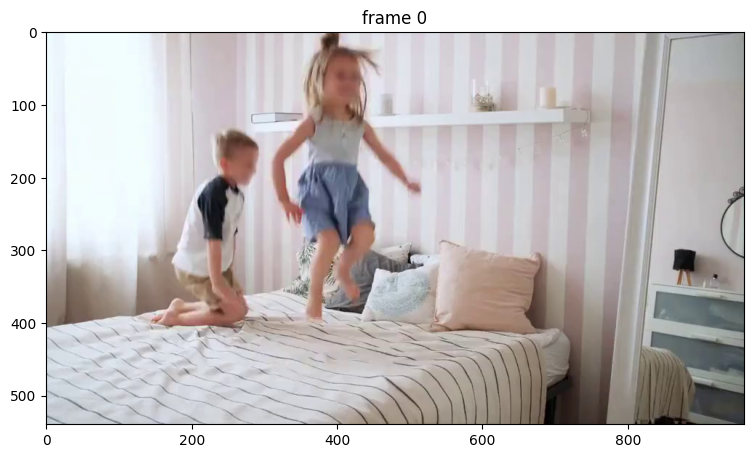

In [9]:
cap = cv2.VideoCapture("./segment-anything-2/notebooks/videos/bedroom/bedroom.mp4")

ret, frame = cap.read()

# opencv uses bgr color mode
# matplotlib uses rgb color mode
# convert the opencv frame to rgb before displaying using matplotlib
rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(rgb_frame)

# Initialize inference state

In [10]:
def preprocess_frame(
    frame: np.ndarray,
    offload_video_to_cpu: bool = False,
    device: torch.device = torch.device("cuda")
) -> torch.Tensor:
    # resize and rescale to [0, 1]
    # image size for sam2-hiera-large
    image_size = 1024
    img = cv2.resize(frame, (image_size, image_size)) / 255.0
    
    # numpy.ndarray -> torch.Tensor
    # (H, W, C) -> (C, H, W)
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    
    img_mean = (0.485, 0.456, 0.406)
    # Convert to torch.Tensor and add two new axes for broading when doing element-wise subtraction with the image
    img_mean = torch.tensor(img_mean, dtype=torch.float32)[:, None, None]
    
    img_std = (0.229, 0.224, 0.225)
    # Convert to torch.Tensor and add two new axes for broadcasting when doing element-wise division with the image
    img_std = torch.tensor(img_std, dtype=torch.float32)[:, None, None]

    if not offload_video_to_cpu:
        img = img.to(device)
        img_mean = img_mean.to(device)
        img_std = img_std.to(device)
    
    img -= img_mean
    img /= img_std
    
    return img.unsqueeze(0)

In [11]:
# a modified version of SAM2VideoPredictor.init_state() that accepts a single frame
@torch.inference_mode()
def init_state(
    frame: np.ndarray,
    offload_video_to_cpu=False,
    offload_state_to_cpu=False,
):
    """Initialize an inference state."""
    compute_device = predictor.device  # device of the model
    inference_state = {}

    video_height = frame.shape[0]
    video_width = frame.shape[1]
    
    img = preprocess_frame(frame, offload_video_to_cpu, compute_device)
    
    inference_state["images"] = img
    inference_state["num_frames"] = 1
    # whether to offload the video frames to CPU memory
    # turning on this option saves the GPU memory with only a very small overhead
    inference_state["offload_video_to_cpu"] = offload_video_to_cpu
    # whether to offload the inference state to CPU memory
    # turning on this option saves the GPU memory at the cost of a lower tracking fps
    # (e.g. in a test case of 768x768 model, fps dropped from 27 to 24 when tracking one object
    # and from 24 to 21 when tracking two objects)
    inference_state["offload_state_to_cpu"] = offload_state_to_cpu
    # the original video height and width, used for resizing final output scores
    inference_state["video_height"] = video_height
    inference_state["video_width"] = video_width
    inference_state["device"] = compute_device
    if offload_state_to_cpu:
        inference_state["storage_device"] = torch.device("cpu")
    else:
        inference_state["storage_device"] = compute_device
    # inputs on each frame
    inference_state["point_inputs_per_obj"] = {}
    inference_state["mask_inputs_per_obj"] = {}
    # visual features on a small number of recently visited frames for quick interactions
    inference_state["cached_features"] = {}
    # values that don't change across frames (so we only need to hold one copy of them)
    inference_state["constants"] = {}
    # mapping between client-side object id and model-side object index
    inference_state["obj_id_to_idx"] = OrderedDict()
    inference_state["obj_idx_to_id"] = OrderedDict()
    inference_state["obj_ids"] = []
    # A storage to hold the model's tracking results and states on each frame
    inference_state["output_dict"] = {
        "cond_frame_outputs": {},  # dict containing {frame_idx: <out>}
        "non_cond_frame_outputs": {},  # dict containing {frame_idx: <out>}
    }
    # Slice (view) of each object tracking results, sharing the same memory with "output_dict"
    inference_state["output_dict_per_obj"] = {}
    # A temporary storage to hold new outputs when user interact with a frame
    # to add clicks or mask (it's merged into "output_dict" before propagation starts)
    inference_state["temp_output_dict_per_obj"] = {}
    # Frames that already holds consolidated outputs from click or mask inputs
    # (we directly use their consolidated outputs during tracking)
    inference_state["consolidated_frame_inds"] = {
        "cond_frame_outputs": set(),  # set containing frame indices
        "non_cond_frame_outputs": set(),  # set containing frame indices
    }
    # metadata for each tracking frame (e.g. which direction it's tracked)
    inference_state["tracking_has_started"] = False
    inference_state["frames_already_tracked"] = {}
    # Warm up the visual backbone and cache the image feature on frame 0
    predictor._get_image_feature(inference_state, frame_idx=0, batch_size=1)
    return inference_state

In [12]:
inference_state = init_state(frame)

AUTOTUNE convolution(1x3x1024x1024, 144x3x7x7)
  convolution 0.1372 ms 100.0%
  triton_convolution_1 0.1536 ms 89.3%
  triton_convolution_6 0.1567 ms 87.6%
  triton_convolution_4 0.1679 ms 81.7%
  triton_convolution_3 0.2191 ms 62.6%
  triton_convolution_5 0.2294 ms 59.8%
  triton_convolution_0 0.2365 ms 58.0%
  triton_convolution_2 0.5315 ms 25.8%
SingleProcess AUTOTUNE takes 4.2191 seconds
AUTOTUNE addmm(65536x432, 65536x144, 144x432)
  triton_mm_9 0.0962 ms 100.0%
  triton_mm_8 0.0963 ms 100.0%
  triton_mm_11 0.0983 ms 97.9%
  triton_mm_10 0.0993 ms 96.9%
  triton_mm_15 0.1014 ms 94.9%
  triton_mm_7 0.1026 ms 93.8%
  bias_addmm 0.1065 ms 90.3%
  triton_mm_12 0.1311 ms 73.4%
  triton_mm_14 0.1372 ms 70.1%
  triton_mm_13 0.1454 ms 66.2%
SingleProcess AUTOTUNE takes 4.6889 seconds
AUTOTUNE mm(65536x144, 144x144)
  triton_mm_21 0.0520 ms 100.0%
  triton_mm_23 0.0522 ms 99.6%
  triton_mm_27 0.0532 ms 97.7%
  triton_mm_19 0.0574 ms 90.6%
  mm 0.0614 ms 84.7%
  triton_mm_20 0.0614 ms 84.7%

In [13]:
# predictor.reset_state(inference_state)

# Step 1. Add a first click on the frame

/home/user/sam2/segment-anything-2/sam2/sam2_video_predictor.py:873: UserWarning: /home/user/sam2/segment-anything-2/sam2/_C.so: undefined symbol: _ZN3c1015SmallVectorBaseIjE8grow_podEPKvmm

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


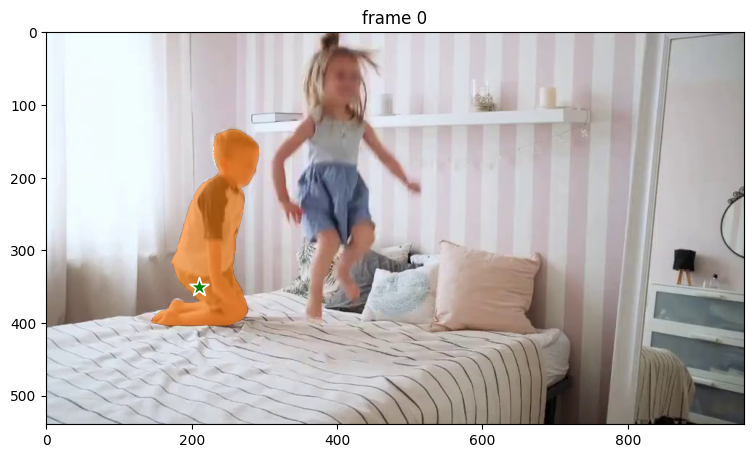

In [14]:
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[210, 350]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(rgb_frame)
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

# Step 2: Propagate masklet through rest of frames

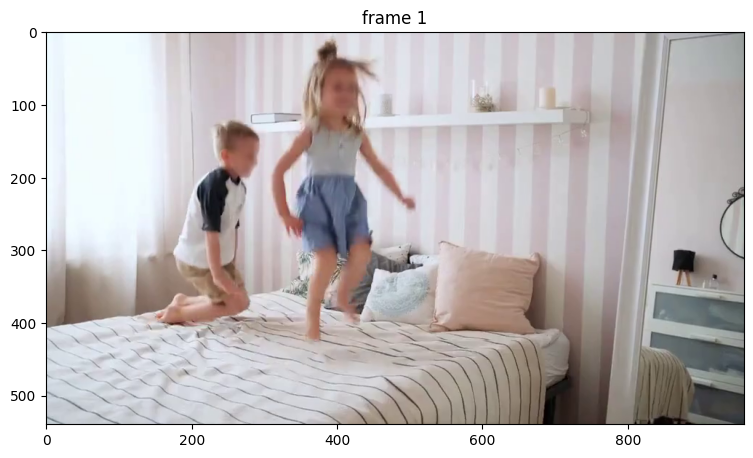

In [15]:
# Next frame
ret, frame = cap.read()
rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

frame_idx += 1
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(rgb_frame)

In [16]:
# modified version of SAM2VideoPredictor._get_image_feature() that accepts the frame
# without caching frame features
def get_image_feature(inference_state, frame, batch_size):
    """Compute the image features on a given frame."""
    image = frame.to(inference_state["device"]).float().unsqueeze(0)
    backbone_out = predictor.forward_image(image)

    # expand the features to have the same dimension as the number of objects
    expanded_image = image.expand(batch_size, -1, -1, -1)
    expanded_backbone_out = {
        "backbone_fpn": backbone_out["backbone_fpn"].copy(),
        "vision_pos_enc": backbone_out["vision_pos_enc"].copy(),
    }
    for i, feat in enumerate(expanded_backbone_out["backbone_fpn"]):
        expanded_backbone_out["backbone_fpn"][i] = feat.expand(
            batch_size, -1, -1, -1
        )
    for i, pos in enumerate(expanded_backbone_out["vision_pos_enc"]):
        pos = pos.expand(batch_size, -1, -1, -1)
        expanded_backbone_out["vision_pos_enc"][i] = pos

    features = predictor._prepare_backbone_features(expanded_backbone_out)
    features = (expanded_image,) + features
    return features

In [17]:
@torch.inference_mode()
def track(inference_state, img):  
    if not inference_state["tracking_has_started"]:
        predictor.propagate_in_video_preflight(inference_state)
    
    inference_state["num_frames"] += 1

    start = time.time()
    img = preprocess_frame(frame)
    print(f"preprocessed frame in {time.time()-start:2f}s")
    
    output_dict = inference_state["output_dict"]
    consolidated_frame_inds = inference_state["consolidated_frame_inds"]
    obj_ids = inference_state["obj_ids"]
    num_frames = inference_state["num_frames"]
    batch_size = predictor._get_obj_num(inference_state)
    if len(output_dict["cond_frame_outputs"]) == 0:
        raise RuntimeError("No points are provided; please add points first")
    clear_non_cond_mem = predictor.clear_non_cond_mem_around_input and (
        self.clear_non_cond_mem_for_multi_obj or batch_size <= 1
    )
    
    (
        _,
        _,
        current_vision_feats,
        current_vision_pos_embeds,
        feat_sizes,
    ) = get_image_feature(inference_state, img.squeeze(0), batch_size)
    
    current_out = predictor.track_step(
        frame_idx=frame_idx,
        is_init_cond_frame=False,
        current_vision_feats=current_vision_feats,
        current_vision_pos_embeds=current_vision_pos_embeds,
        feat_sizes=feat_sizes,
        point_inputs=None,
        mask_inputs=None,
        output_dict=output_dict,
        num_frames=inference_state["num_frames"],
        track_in_reverse=False,
        run_mem_encoder=True,
        prev_sam_mask_logits=None,
    )

    # optionally offload the output to CPU memory to save GPU space
    storage_device = inference_state["storage_device"]
    maskmem_features = current_out["maskmem_features"]
    if maskmem_features is not None:
        maskmem_features = maskmem_features.to(torch.bfloat16)
        maskmem_features = maskmem_features.to(storage_device, non_blocking=True)
    pred_masks_gpu = current_out["pred_masks"]
    # potentially fill holes in the predicted masks
    # if predictor.fill_hole_area > 0:
    #     pred_masks_gpu = fill_holes_in_mask_scores(
    #         pred_masks_gpu, predictor.fill_hole_area
    #     )
    pred_masks = pred_masks_gpu.to(storage_device, non_blocking=True)
    # "maskmem_pos_enc" is the same across frames, so we only need to store one copy of it
    maskmem_pos_enc = predictor._get_maskmem_pos_enc(inference_state, current_out)
    # object pointer is a small tensor, so we always keep it on GPU memory for fast access
    obj_ptr = current_out["obj_ptr"]
    # make a compact version of this frame's output to reduce the state size
    compact_current_out = {
        "maskmem_features": maskmem_features,
        "maskmem_pos_enc": maskmem_pos_enc,
        "pred_masks": pred_masks,
        "obj_ptr": obj_ptr,
    }

    output_dict["non_cond_frame_outputs"][frame_idx] = compact_current_out

    _, video_res_masks = predictor._get_orig_video_res_output(inference_state, pred_masks)

    return obj_ids, video_res_masks

In [18]:
out_obj_ids, out_mask_logits = track(inference_state, frame)

preprocessed frame in 0.011312s


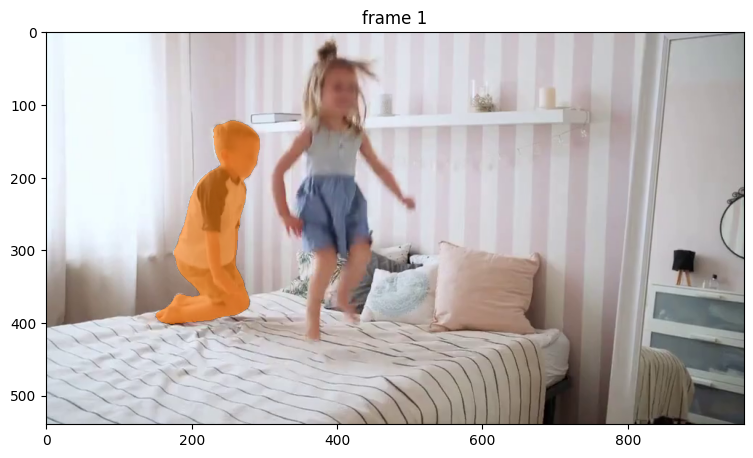

In [19]:
# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(rgb_frame)
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [20]:
video_segments = {}
rgb_frames = {}
i = 0

while frame_idx < 20:
    start = time.time()
    ret, frame = cap.read()
    print(f"decoded frame in {time.time()-start:2f}s")
    
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    frame_idx += 1

    start = time.time()
    out_obj_ids, out_mask_logits = track(inference_state, frame)
    print(f"tracked obj in {time.time()-start:2f}s")

    video_segments[frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy() for i, out_obj_id in enumerate(out_obj_ids)
    }
    rgb_frames[frame_idx] = rgb_frame

decoded frame in 0.000800s
preprocessed frame in 0.011820s
tracked obj in 0.044529s
decoded frame in 0.000530s
preprocessed frame in 0.008012s
tracked obj in 0.041367s
decoded frame in 0.000566s
preprocessed frame in 0.007905s
tracked obj in 0.041453s
decoded frame in 0.000655s
preprocessed frame in 0.008723s
tracked obj in 0.042806s
decoded frame in 0.000519s
preprocessed frame in 0.007895s
tracked obj in 0.042180s
decoded frame in 0.000635s
preprocessed frame in 0.008719s
tracked obj in 0.042462s
decoded frame in 0.000526s
preprocessed frame in 0.011165s
tracked obj in 0.048053s
decoded frame in 0.000653s
preprocessed frame in 0.011648s
tracked obj in 0.048611s
decoded frame in 0.000648s
preprocessed frame in 0.008081s
tracked obj in 0.041790s
decoded frame in 0.000577s
preprocessed frame in 0.010485s
tracked obj in 0.044747s
decoded frame in 0.000495s
preprocessed frame in 0.010438s
tracked obj in 0.044094s
decoded frame in 0.000529s
preprocessed frame in 0.007189s
tracked obj in 0.

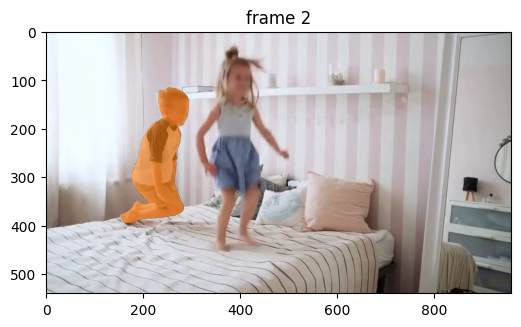

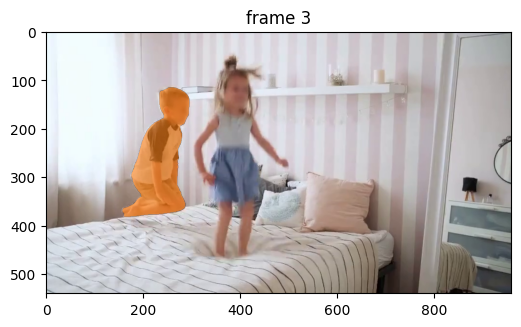

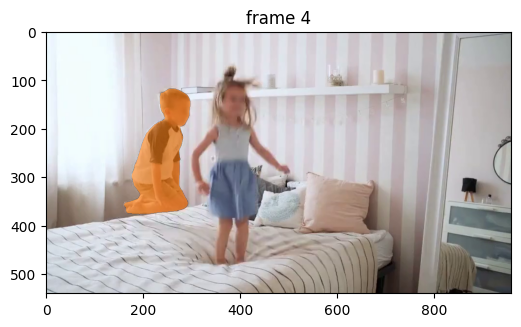

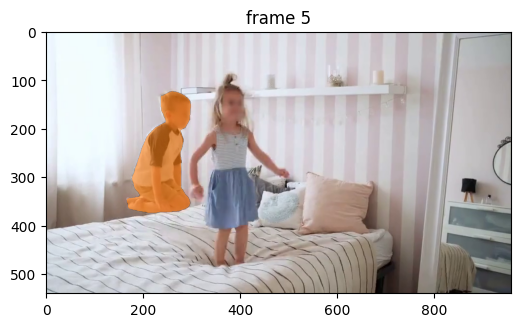

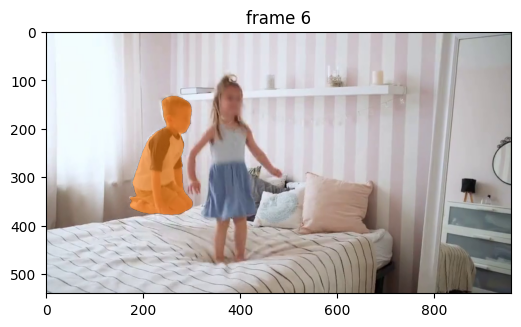

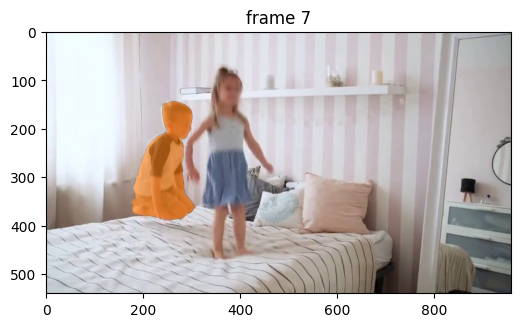

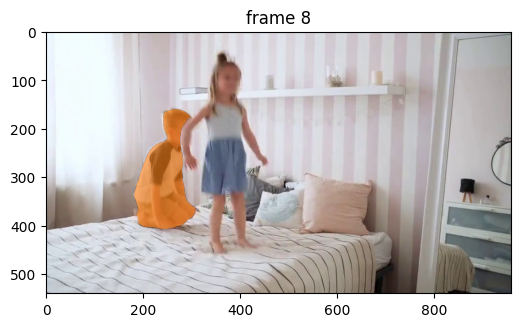

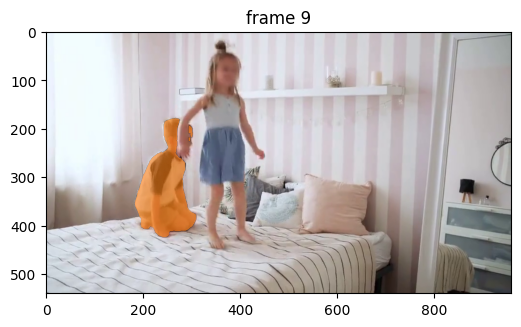

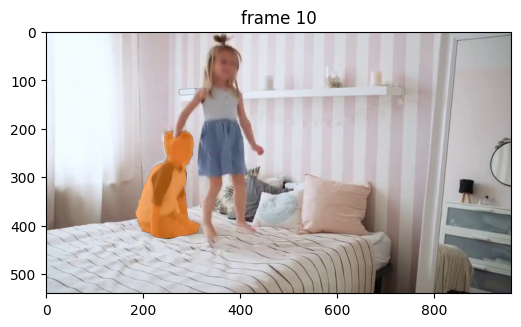

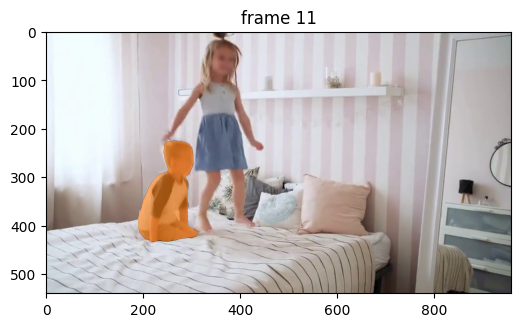

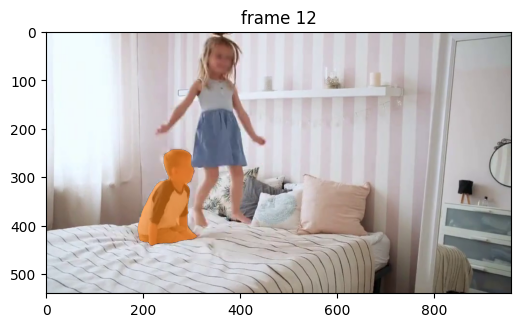

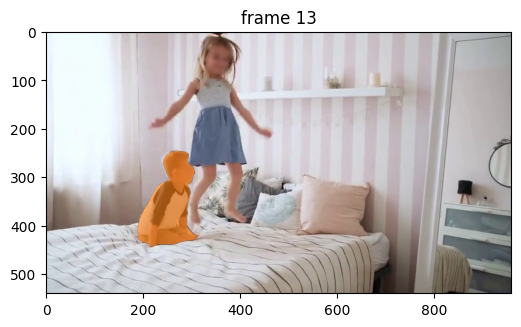

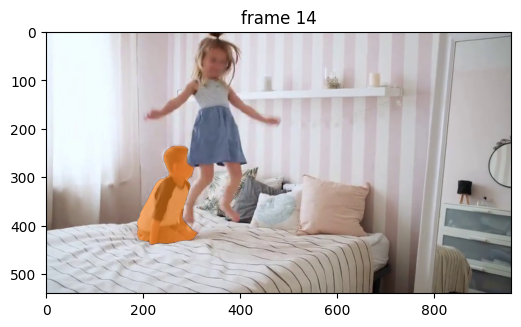

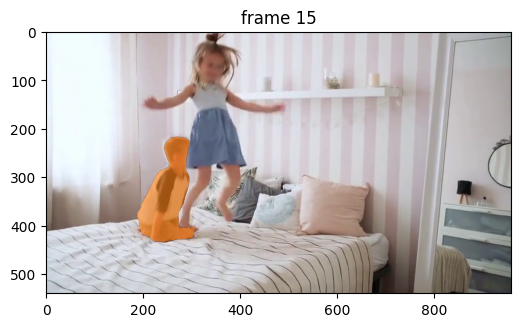

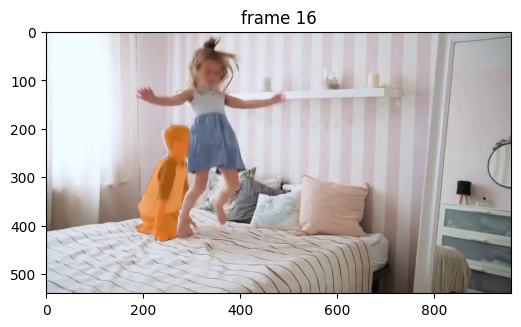

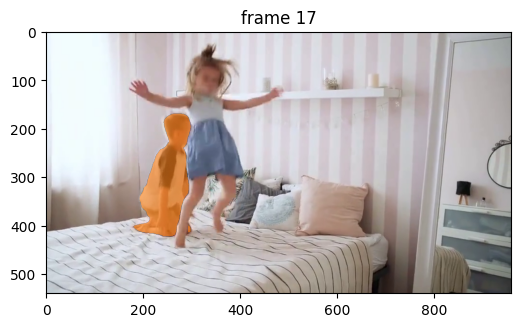

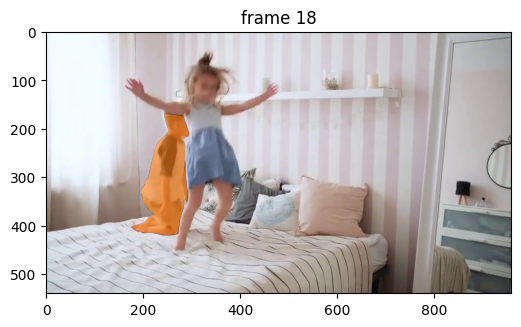

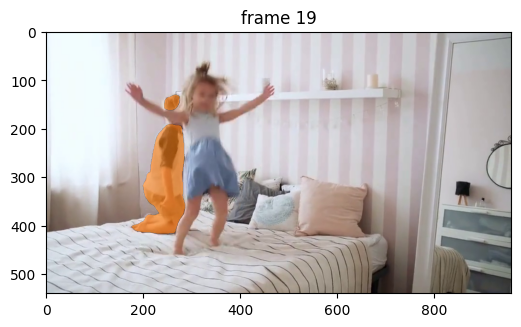

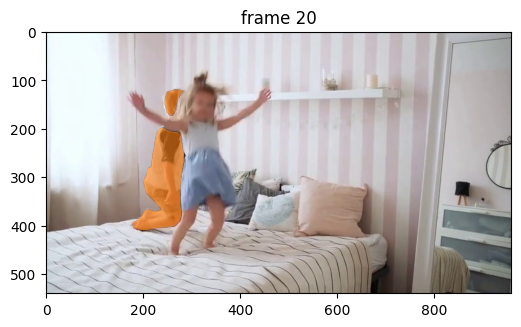

In [21]:
plt.close("all")
for frame_idx in video_segments:
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {frame_idx}")
    plt.imshow(rgb_frames[frame_idx])
    for out_obj_id, out_mask in video_segments[frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)